In [119]:
import math
import random
import torch
import matplotlib.pyplot as plt
from scipy.spatial import distance
import itertools
import jellyfish
import numpy as np

In [390]:
%run partial_words.py
%run core.py
%run imgCls.py

In [7]:
def choose_words(nm):
    return random.choices(sbst,k=nm)



In [12]:
len(choose_words(5000))

5000

In [ ]:
sbst

In [ ]:
spl_Tree = {}

In [104]:
for p in itertools.permutations([1,2,3,4,5],2):
    print(p)

(1, 2)
(1, 3)
(1, 4)
(1, 5)
(2, 1)
(2, 3)
(2, 4)
(2, 5)
(3, 1)
(3, 2)
(3, 4)
(3, 5)
(4, 1)
(4, 2)
(4, 3)
(4, 5)
(5, 1)
(5, 2)
(5, 3)
(5, 4)


In [276]:

def name_path(name):
    return "./net_data/" + name + ".bin"
def save_network(ntwrk,name):
    nt_path = name_path(name)
    torch.save(ntwrk.state_dict(),nt_path)
    return

def load_network(name):
    nt_pth = name_path(name)
    return torch.load(nt_pth)



In [378]:
def test_words(wrds):
    wrl = WordManage()
    wrl.set_words(wrds,0)
    mdl = build_choose_and_train(wrl,dbg=True)
    wrds = wrl.all_words()
    cats = get_category(mdl,wrds,dbg=True)
    print("categories... ",cats)
    return

In [386]:
test_wrds = ['election', 'reaction']


In [392]:
test_words(test_wrds)

word  reaction  category  0
word  election  category  1
word  reaction  mix  rggeaction  category  0
word  election  mix  laection  category  1
word  reaction  mix  erabcion  category  0
word  election  mix  lejcion  category  1
word  reaction  mix  raecti n  category  0
word  election  mix  lection  category  1
word  reaction  mix  reactidn  category  0
word  election  mix  eelction  category  1
word  reaction  mix  reacwion  category  0
word  election  mix  elecio  category  1
word  reaction  mix  eralctibon  category  0
word  election  mix  eeoection  category  1
word  reaction  mix  recaion  category  0
word  election  mix  eq ection  category  1
word  reaction  mix  repction  category  0
word  election  mix  ele jion  category  1
word  reaction  mix  renctoin  category  0
word  election  mix  electaino  category  1
word  reaction  mix  r  ction  category  0
word  election  mix  electnon  category  1
word  reaction  mix  reactioo  category  0
word  election  mix  elrectipn  categor

In [98]:
im = ImgNet(5)
im.apply(custom_init_weights)
im = best_move(im)
get_category(im,['Chris','Schrumm','Programmer','Test','Nice','Some','Zero','Whatever','Mouse','Other'])

normal init..
normal init..
['Chris', 'Schrumm', 'Programmer', 'Test', 'Nice', 'Some', 'Zero', 'Whatever', 'Mouse', 'Other']
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')


array([[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]])

In [88]:
tensor_info(numpy_to_tensor(np.array([3,4,5])))

(device(type='cuda', index=0), torch.Size([3]), torch.int64)

In [76]:
ww = word_batch(['Chris','Schrumm'])

In [77]:
def display_im(im):
    plt.figure(figsize=(25, 150),dpi=80)
    plt.imshow(im)

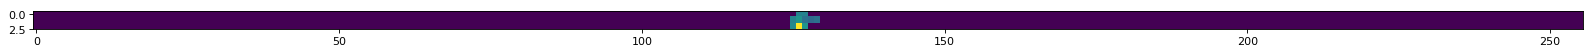

In [79]:
display_im(ww[0][0])

In [34]:
tt = numpy_to_tensor(np.array([3,4,5]))
tt.to(best_device())
tensor_info(tt)

(device(type='cpu'), torch.Size([3]), torch.int64)

In [10]:
word_batch(["chris","schrumm"]).shape

(2, 1, 3, 256)

In [354]:
# rtTreeName contains the name of the network to load 
# avWords (instance of WordManage) contains the list of available words.
# wdDic contains the chosen words root network choice
# maxDepth
def train_and_choose(rtTreeName, avWords, wdDic, maxDepth, btch_count):
    '''
    Note: Tree Name is the following format.. RootName_Subcategory_Subcategory_Subcategory_SubCategory
           where subcategory is a number 0 to 4
    1. Choose N words from avWords min(300,avWords.count)
    2. Create a new instance of get_network with rtTreeName
    3. For the chosen words do the following
        A. find out the category 1 through (category_count) of the words
        B. Now for train_batch count modify all the words using the initially selected
           word as the target.
    4. Now for all words in avWords assign them to on of the (categor_count) categories
    5. Save the network.
    6. If maxDepth <= 1 return..
    7. For 1 to (cagtegory_count) number of categories:
            maxDepth = maxDepth - 1
            A. Select all the elements of chosen category from the avWords.filter_cat(category)
               and append them to a new instance of avWords
            B. If there is more then one element in a category...
               B1. Recursively call train_and_choose with new avWords category and the sub network
                   name netname_ + category_number
            
    '''
    print("train tree..")
    mdl = build_choose_and_train(avWords)
   
    # write the code to save the model..
    save_network(mdl,rtTreeName)

    all_wrds = avWords.all_words()

    #print(type(all_wrds),"      ",type(all_wrds[0]))

    cat_w = get_category(mdl,all_wrds)

    for i,wrd in enumerate(all_wrds):
        #print(wrd,"  ",cat_w[i])
        avWords.set_category(wrd,cat_w[i])
   
    if maxDepth <= 0:
        print("max depth exceeded..")
        return

    for i in range(5):
        sb_tree = rtTreeName + "_" + str(i)
        nw_wrl = avWords.filter_list(i)
        
        for w in nw_wrl.all_words():
            wdDic[w] = sb_tree
    
        print("category ",i," total word count ",len(nw_wrl.all_words()))
    
        # recurse..
        wrds = nw_wrl.all_words()
        if len(wrds) > 1:
            # recurse..
            print("recursing on ",sb_tree," total words.. ", len(wrds))    
            if len(wrds) < 5:
                print("Words..",wrds)
            train_and_choose(sb_tree, nw_wrl, wdDic, maxDepth - 1, btch_count)
    return

def spell_word(word,nd,wrList):
    '''
       NOT FINISHED...
       1. Load the network name.
       2. Find category for the word in the network.
       3. If wrList.has_more_one(category)
            with spell_word with word and netname_ + category_number
          elif wrList.has_one(category):
            
           
    '''
    pass

In [360]:
rt_name = "mdl_spelling"
dcMapping = {}
maxDepth = 30
btch_size = 128

train_and_choose(rt_name,wrl,dcMapping,maxDepth,btch_size)


train tree..
category  0  total word count  239
recursing on  mdl_spelling_0  total words..  239
train tree..
category  0  total word count  8
recursing on  mdl_spelling_0_0  total words..  8
train tree..
category  0  total word count  2
recursing on  mdl_spelling_0_0_0  total words..  2
Words.. ['magazine', 'sandwich']
train tree..
category  0  total word count  1
category  1  total word count  1
category  2  total word count  0
category  3  total word count  0
category  4  total word count  0
category  1  total word count  3
recursing on  mdl_spelling_0_0_1  total words..  3
Words.. ['departure', 'structure', 'beautiful']
train tree..
category  0  total word count  1
category  1  total word count  1
category  2  total word count  1
category  3  total word count  0
category  4  total word count  0
category  2  total word count  1
category  3  total word count  1
category  4  total word count  1
category  1  total word count  124
recursing on  mdl_spelling_0_1  total words..  124
train

KeyboardInterrupt: 

In [343]:
wrl = WordManage()

In [344]:
wrl.set_words(sbst,0)

In [345]:
wrl.word_count()

1525

In [221]:
def remove_letter(wd):
    if len(wd) < 5:
        return wd
    cs = random.randint(0,len(wd)-1)
    return wd[0:cs] + wd[cs+1:]

def swap_letter(wd):
    if len(wd) < 3:
        return wd
    cs = random.randint(0,len(wd)-2)
    wd = [w for w in wd]
    t = wd[cs]
    wd[cs] = wd[cs+1]
    wd[cs+1] = t
    
    tmp = ""
    for w in wd:
        tmp += w
        
    return tmp

def change_letter(wd):    
    if len(wd) < 4:
        return wd
    
    alpha = ['a','b','c','d','e','f','g', \
        'h','i','j','k','l','m','n','o','p','q','r', \
        's','t','u','v','w','x','y','z']
    cs = random.randint(0,len(wd)-1)

    wd = [w for w in wd]
    
    wd[cs] = alpha[random.randint(0,25)]
    
    tmp = ""
    for w in wd:
        tmp += w
        
    return tmp

def drop_letter(wd):
    if len(wd) < 5:
        return wd
    cs = random.randint(0,len(wd)-2)
    
    wd = [w for w in wd]
    
    wd[cs] = ' '
    
    tmp = ""
    for w in wd:
        tmp += w
        
    return tmp   

def add_letter(wd):
    if len(wd) < 3:
        return wd
    
    #print("add letter")
    cs = random.randint(0,len(wd)-2)
    
    #wd = [w for w in wd]
    
    alpha = ['a','b','c','d','e','f','g', \
        'h','i','j','k','l','m','n','o','p','q','r', \
        's','t','u','v','w','x','y','z']
    
    #ln = len(wd)
    wd = wd[0:cs] + alpha[random.randint(0,25)] + wd[cs:] 
           
    return wd 


def word_mix(wd):
    fc_ar = [remove_letter,swap_letter,change_letter,drop_letter,add_letter]
    
    wd = fc_ar[random.randint(0,4)](wd)
    
    if random.random() < 0.4:
        wd = fc_ar[random.randint(0,4)](wd)
        
    if random.random() < 0.3:
        wd = fc_ar[random.randint(0,4)](wd)
        
    if random.random() < 0.2:
        wd = fc_ar[random.randint(0,4)](wd)
        
    return wd


In [205]:
nn = "chris"
print(nn[0:3] + nn[3:])

chris


In [220]:
s = "transportation"
print(len(s))

for i in range(100):    
    nw_s = word_mix(s)
    print(nw_s,"  ",len(nw_s))


14
transporta ion    14
transpportation    15
transport tion    14
transportatcion    15
 rans p tation    14
t asportation    13
transpportatiqn    15
tpransoprtation    15
tansp rtation    13
trnlasportation    15
tqansportatio    13
transportagion    14
transport  ion    14
t ansportation    14
yransportation    14
trazsportation    14
transportatdob    14
trmansportatijn    15
transporation    13
ctransportation    15
tr nsportation    14
 arnsportation    14
trntportation    13
trlansportation    15
transportatjion    15
transqportation    15
transpo rati n    14
transpritation    14
transporattion    14
vrrnsportation    14
transpotratiol    14
transporation    13
transmportatin    14
trangspiortation    16
t nsportation    13
transportjtion    14
transfortation    14
rtnsportation    13
trhanspoktation    15
trns rtatifon    13
trsnportation    13
transposrtation    15
tratlportaiton    14
tqanlsportation    15
ransportation    13
transportatiol    14
tranjpoxrtation    15
ransp

In [147]:
for i in range(30):
    print(random.randint(0,4))

2
1
0
3
4
4
4
1
4
0
1
4
3
0
2
2
1
3
4
2
2
2
3
3
0
2
1
0
0
2


In [328]:
vl = "nice"
        

In [331]:
rtTreeName = "mdl_spelling"
avWords = wrl
wdDic = {}

False

In [336]:
mdl = build_choose_and_train(avWords)

In [339]:

# write the code to save the model..
# save_network(mdl,rtTreeName)

all_wrds = avWords.all_words()

#print(type(all_wrds),"      ",type(all_wrds[0]))

cat_w = get_category(mdl,all_wrds)

for i,wrd in enumerate(all_wrds):
    #print(wrd,"  ",cat_w[i])
    avWords.set_category(wrd,cat_w[i])
   

for i in range(5):
    sb_tree = rtTreeName + "_" + str(i)
    nw_wrl = avWords.filter_list(i)
    for w in nw_wrl.all_words():
        wdDic[w] = sb_tree
    
    print("category ",i," total word count ",len(nw_wrl.all_words()))
    # recurse..
    wrds = nw_wrl.all_words()
    if len(wrds) > 0:
        # recurse..
        print("recursing on ",sb_tree)
        # train_and_choose(sb_tree, nw_wrl, wdDic, maxDepth, btch_count

<class 'list'>        <class 'str'>
category  0  total word count  104
recursing on  mdl_spelling_0
category  1  total word count  1089
recursing on  mdl_spelling_1
category  2  total word count  182
recursing on  mdl_spelling_2
category  3  total word count  137
recursing on  mdl_spelling_3
category  4  total word count  13
recursing on  mdl_spelling_4


In [340]:
wdDic

{'software': 'mdl_spelling_0',
 'knowledge': 'mdl_spelling_0',
 'economics': 'mdl_spelling_0',
 'society': 'mdl_spelling_0',
 'activity': 'mdl_spelling_0',
 'community': 'mdl_spelling_0',
 'quality': 'mdl_spelling_0',
 'equipment': 'mdl_spelling_0',
 'analysis': 'mdl_spelling_0',
 'boyfriend': 'mdl_spelling_0',
 'strategy': 'mdl_spelling_0',
 'audience': 'mdl_spelling_0',
 'marriage': 'mdl_spelling_0',
 'chemistry': 'mdl_spelling_0',
 'addition': 'mdl_spelling_0',
 'education': 'mdl_spelling_0',
 'painting': 'mdl_spelling_0',
 'politics': 'mdl_spelling_0',
 'cigarette': 'mdl_spelling_0',
 'inflation': 'mdl_spelling_0',
 'importance': 'mdl_spelling_0',
 'perspective': 'mdl_spelling_0',
 'patience': 'mdl_spelling_0',
 'attitude': 'mdl_spelling_0',
 'psychology': 'mdl_spelling_0',
 'emphasis': 'mdl_spelling_0',
 'membership': 'mdl_spelling_0',
 'currency': 'mdl_spelling_0',
 'employment': 'mdl_spelling_0',
 'republic': 'mdl_spelling_0',
 'difficulty': 'mdl_spelling_0',
 'football': 'mdl_s

In [298]:
save_network(mdl,"test")

In [306]:
mdl = best_move(ImgNet(5))
load_data_into(mdl,"test")
#mdl = load_network("test")

In [59]:
wrl.set_category('bike',2)
wrl.set_category('cause',2)
wrl.set_category('clerk',2)

In [61]:
l = wrl.filter_list(2)

In [65]:
l.choose_words(3)

['clerk', 'cause', 'bike']